# UNET Multi Input t, t+1, t-1

In [7]:
import os 
import pandas as pd
import pydicom as dicom
import numpy as np
import matplotlib.pylab as plt

from utils_prepro import * # particular functions to make a data set multi input
from data_loader_seg_mult_input import Segmentation_after_before
from unet_3block_multiple_input import UNET_multi


In [8]:
import sys 
# setting scripts/utils path
sys.path.append(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Proba_UNET')
from create_images_3_classes import *
from training import *
from loss import *
from model_prob_unet_init import *
from test import *

## Pre-analysys

In [15]:
import cv2
def str_after_before(idx):
    '''
    A function to combine the indexation on t+1 and t-1 wrt the actual image (t)
    '''
    if idx >=0 and idx <100:
        idx_str = str(0)+str(0)+str(idx)
    if idx >=100 and idx <1000:
        idx_str = str(0)+str(idx)
    if idx >=1000:
        idx_str = str(idx)
    return idx_str

def create_path_after_before(path_mct , names, names_files):
    '''
    YA NO.... Pilas aqui cuando vaya a utilizarlo con las demas carpetas porque hago un zip entre los directorios y los names que tengo disponibles
    Creation of path for images at time t-1 and t+1 wrt to the actual image t (image with its true mask)
    '''
    path_mct_files = []
    for path_, name in zip(path_mct, names_files):
        path_mct_files += [os.path.join(path_, f+'.dcm')   for f in names if name in f and f+'.dcm' in os.listdir(path_)]
    return path_mct_files
    
def read_image_dicom(imagePath):
    ''' 
    Lecture of DICOM images, it includes  normalization and transformation to gray scale (2 dimensions) 
    '''
    image = dicom.dcmread(imagePath).pixel_array
    # image =  cv2.normalize(image.astype(np.float32),  None, 0, 255, cv2.NORM_MINMAX)
    # image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)/255
    return image
  

def box_image_seg(mask, img, error, Area = 50):
    '''
    From an image we can get several images for training
    It depends on the minimun area to create a nwe image
    It means we have several boxes information which contain localisation information of calcifications  
    '''
    masks_imgs = []
    imgs = []
    box_info = []
    label = (mask!=0)*1
    contours , _ = cv2.findContours(label.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    idxs =  list(np.where(np.array([cv2.contourArea(x) for x in contours])>Area))[0]
    #print(idxs)
    #j = int(np.where([cv2.contourArea(x) for x in contours] == np.max([cv2.contourArea(x) for x in contours]))[0][0])
    pix  = np.sum(label)
    if pix > 12 and len(idxs)>0:   
        for idx in idxs:
            x,y,w,h = cv2.boundingRect(contours[int(idx)])
            #print(x,y,w,h)
            masks_imgs.append(mask[y-error:y+h+error,x-error:x+w+error])
            imgs.append(img[y-error:y+h+error,x-error:x+w+error])
            box_info.append([x,y,w,h])
    
    return masks_imgs, imgs,  box_info


def create_box_images_after_before(image_Paths, mask_Paths, error, Area):
    image_list = []
    mask_list = []
    box_list = []

    for idx in range(len(mask_Paths)):
        mask =  create_binary_mask(mask_Paths[idx])
        image = read_image(image_Paths[idx], False )
        masks_imgs, imgs, boxes = box_image_seg(mask, image, error, Area)
        image_list += imgs
        mask_list+= masks_imgs
        box_list.append(boxes)
    
    return image_list, mask_list, box_list

def read_image_after_before(path , path_after, path_before, mask_Path, error, Area):
    '''
    Create a list of images with a box list (from one image) for  each image at time t, t+1 and t-1
    '''
    image_list = []
    image = read_image_dicom(path)
    image_after = read_image_dicom(path_after)
    image_before = read_image_dicom(path_before)
    mask =  create_binary_mask(mask_Path)
    masks_imgs, imgs, boxes = box_image_seg(mask, image, error, Area)
    for box in boxes:
        x,y,w,h =  box
        # print(x,y,w,h)
        # print(image.shape)
        img = [image[y-error:y+h+error,x-error:x+w+error], image_after[y-error:y+h+error,x-error:x+w+error] , image_before[y-error:y+h+error,x-error:x+w+error]] 
        image_list.append(img)
    return image_list, masks_imgs

def create_image_after_before(info_image, info_image_after_before, error, Area):
    '''
    info_image  dictionary 
    keys: file name
    values: mask, boxes, images (time t)

    info_image_after_before dictionary
    keys: file names
    values: path image at time t, path (t+1), path (t-1)
    '''
    image_list = []
    mask_list = []
    for key in list(info_image_after_before):
        #print(key)
        mask_Path  = info_image[key]
        path , path_after, path_before = info_image_after_before[key]
        #print(mask_Path[0].split('\\')[-1][:-4] ,'\n', path.split('\\')[-1][:-4] , '\n',path_after.split('\\')[-1][:-4], '\n',path_before.split('\\')[-1][:-4],'\n', key)
        imgs, masks_imgs = read_image_after_before(path , path_after, path_before, mask_Path, error, Area)
        image_list += imgs
        mask_list += masks_imgs

    return image_list, mask_list


def create_multi_input_data(error, Area, train_ = True):
    '''
    Create a multi inpu data set t, t+1, t-1
    '''
    path_ori = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\originals_180919\originals'
    path = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers'
    path_MCTS = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\MicroCT_data'
    path_mcts = [os.path.join(path_MCTS, f) for f in os.listdir(path_MCTS)]
    names_files = [f for f in os.listdir(path_MCTS)]#print(path_mcts)

    # 1. Names of availables images (mask +images) at time t
    image_Paths, mask_Paths = create_dir_paths(path, train=train_)
    #########
    #image_list , mask_list, boxes =  create_box_images_after_before(image_Paths, mask_Paths, error, Area)
    #########
    info_image_dic = [[i[0].split('\\')[-1].split('.')[0].replace('-A', '').replace('_A', ''), i] for i in mask_Paths]
    info_image = {info_image_dic[i][0]: info_image_dic[i][1] for i in range(len(info_image_dic))}
    names = list(info_image.keys())
    names_after = [file[:-4]+str_after_before(int(file[-4:]) + 1) for file in names]
    names_before = [file[:-4]+str_after_before(int(file[-4:]) - 1) for file in names]

    # 2. Creation of paths t, t-1, t+1
    image_Paths_actual = create_path_after_before(path_mcts , names, names_files)
    image_Paths_after = create_path_after_before(path_mcts , names_after, names_files)
    image_Paths_before = create_path_after_before(path_mcts , names_before, names_files)
    #print(len(image_Paths_actual), len(image_Paths_after), len(image_Paths_before))

    # 3. Saving the information using a dictionary 
    names_after_before = [path.split('\\')[-1][:-4] for path in image_Paths_actual]
    info_image_after_before = {names_after_before[i]: [image_Paths_actual[i], image_Paths_after[i], image_Paths_before[i] ]for i in range(len(names_after_before))}
    # for i , j, k , n  in zip(image_Paths_actual, image_Paths_after , image_Paths_before, names_after_before):
    #     print('\n',i.split('\\')[-1][:-4], '\n', j.split('\\')[-1][:-4], '\n', k.split('\\')[-1][:-4], '\n', n)

    # 4. Lists which contain microCT at time t, t+1, t-1 and the mask asociated 
    image_list, mask_list = create_image_after_before(info_image, info_image_after_before, error, Area)

    # print('number of images:', len(image_Paths), len(mask_Paths))
    # print('nombres disponibles: ', len(names))
    return image_list, mask_list 

 def norm_image_2d_to_3d(image):
    image =  cv2.normalize(image.astype(np.float32),  None, 0, 255, cv2.NORM_MINMAX)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)/255
    return image    


In [16]:
#---------------------
# 0. Data parameters to create the dataset 
error = 25
Area = 80
image_shape = (128, 128) 
batch_size = 2
train =  True
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
print('Images and masks are created')
print(len(image_list), len(mask_list))  


# path_ori = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\originals_180919\originals'
# path = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers'
# path_MCTS = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\MicroCT_data'
# path_mcts = [os.path.join(path_MCTS, f) for f in os.listdir(path_MCTS)]
# names_files = [f for f in os.listdir(path_MCTS)]#print(path_mcts)
# print('names files: ', len(names_files))
# number_files = [len(os.listdir(path)) for path in path_mcts]
# for i, j in zip(os.listdir(path_MCTS),number_files):
#     print(i, ':', j)
    
# # 1. Names of availables images (mask +images) at time t
# image_Paths, mask_Paths = create_dir_paths(path, train=train_)
# print('number of images:', len(image_Paths), len(mask_Paths))
# #########
# #image_list , mask_list, boxes =  create_box_images_after_before(image_Paths, mask_Paths, error, Area)
# #########
# info_image_dic = [[i[0].split('\\')[-1].split('.')[0].replace('-A', '').replace('_A', ''), i] for i in mask_Paths]
# info_image = {info_image_dic[i][0]: info_image_dic[i][1] for i in range(len(info_image_dic))}
# names = list(info_image.keys())
# print('names: ', len(names))
# numbers_after = [int(file[-4:]) for file in names]
# names_after = [file[:-4]+str_after_before(int(file[-4:]) + 1) for file in names]
# names_before = [file[:-4]+str_after_before(int(file[-4:]) - 1) for file in names]
# print('names after: ', len(names_after))
# print('names before: ', len(names_before))
# # 2. Creation of paths t, t-1, t+1
# image_Paths_actual = create_path_after_before(path_mcts , names, names_files)
# image_Paths_after = create_path_after_before(path_mcts , names_after, names_files)
# image_Paths_before = create_path_after_before(path_mcts , names_before, names_files)
# print('Numer of paths',len(image_Paths_actual), len(image_Paths_after), len(image_Paths_before))

# # 3. Saving the information sing a dictionary 
# names_after_before = [path.split('\\')[-1][:-4] for path in image_Paths_actual]
# print('nombres after before: ', len(names_after_before))
# info_image_after_before = {names_after_before[i]: [image_Paths_actual[i], image_Paths_after[i], image_Paths_before[i] ]for i in range(len(names_after_before))}
# # for i , j, k , n  in zip(image_Paths_actual, image_Paths_after , image_Paths_before, names_after_before):
# #     print('\n',i.split('\\')[-1][:-4], '\n', j.split('\\')[-1][:-4], '\n', k.split('\\')[-1][:-4], '\n', n)

# # 4. Lists which contain microCT at time t, t+1, t-1 and the mask asociated 
# image_list, mask_list = create_image_after_before(info_image, info_image_after_before, error, Area)

# # print('number of images:', len(image_Paths), len(mask_Paths))
# # print('nombres disponibles: ', len(names))
# # image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
# print('Images and masks are created')
# print(len(image_list), len(mask_list))  


78
76 76 76
76 76 76 76
Images and masks are created
143 143


In [28]:
def data_after_before(image_list):
    image_list_complet = []
    for im in image_list:
        image_list_complet += im
    # print(len(image_list_complet))
    # print(image_list_complet[0].shape)
    max_v  = np.max([np.max(im) for im in image_list_complet])
    min_v  = np.min([np.min(im) for im in image_list_complet])
    # print(max_v , min_v)
    image_list_complet_norm = [ (im-  min_v)/(max_v -  min_v) for im in image_list_complet]
    image_list  = [ [norm_image_2d_to_3d(image_list_complet_norm[3*i]),norm_image_2d_to_3d(image_list_complet_norm[3*i+1]),norm_image_2d_to_3d(image_list_complet_norm[3*i+2])]  for i in np.arange(len(image_list_complet_norm)//3)] 
    print('Images are created')
    print(len(image_list)) 
    return image_list 

    # max_vsr  = [np.max([np.max(im[:,:,0]) for im in image_list_complet]), np.max([np.max(im[:,:,1]) for im in image_list_complet]), np.max([np.max(im[:,:,2]) for im in image_list_complet])]
    # min_vsr  = [np.min([np.min(im[:,:,0]) for im in image_list_complet]), np.min([np.min(im[:,:,1]) for im in image_list_complet]), np.min([np.min(im[:,:,2]) for im in image_list_complet])]
    # print(max_vsr , min_vsr)
    # #image_list_completages = [im/ for im in image_list_complet]


In [5]:
path = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers'
train_ = True 
image_Paths, mask_Paths = create_dir_paths(path, train=train_)

78
76 76 76
76 76 76 76


In [6]:
image_Paths

['C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Dist_0366.A.7.1.5.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_0197.A.5.1.1.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_0275.A.4.1.6.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_0372.A.4.1.5.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_0725.A.4.1.1.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_0915.A.3.1.5.grayscale.png',
 'C:\\Users\\kmorales\\Desktop\\2DO PhD\\Strasbourg\\Hugo_seg\\ora_180919\\Layers\\train\\mask\\CV40641_SFA001_Prox_1100_A.3.1.3.g

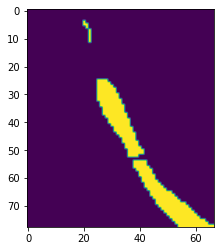

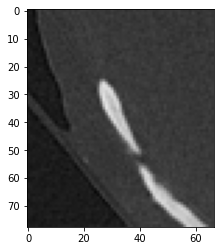

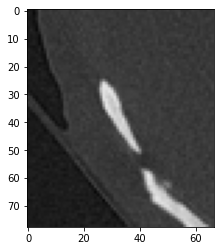

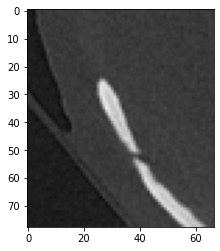

In [38]:
i = np.random.randint(0, len(mask_list))
plt.imshow(mask_list[i])
plt.show()
plt.imshow(image_list[i][0])
plt.show()
plt.imshow(image_list[i][1])
plt.show()
plt.imshow(image_list[i][2])
plt.show()

In [39]:
# from torch.utils.data import Dataset
# import cv2
# import torch 
# class Segmentation_after_before(Dataset):
#     def __init__(self, imageList, maskList, image_shape, transforms = None, error = 20):
#         # store the image and mask filepaths, and augmentation
#         # transforms
#         self.imageList = imageList
#         self.maskList = maskList
#         self.transforms = transforms
#         self.error  =  error
#         self.image_shape =  image_shape
#         #self.training = training
#     def __len__(self):
#         return len(self.imageList)

#     def _get_tensor_image_(self, image):
#         image = cv2.resize(image, self.image_shape, interpolation=cv2.INTER_NEAREST)
#         image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)
#         if self.transforms is not None:
#             transformed = self.transforms(image=image)
#             image = transformed["image"]
#         return image
        
#     def __getitem__(self, idx):
#         # grab the image path from the current index
#         # t, t+1, t-1 
#         image_t  = self._get_tensor_image_(self.imageList[idx][0])
#         image_after  = self._get_tensor_image_(self.imageList[idx][1])
#         image_before  = self._get_tensor_image_(self.imageList[idx][2])
        
#         mask = self.maskList[idx]
#         mask = cv2.resize(mask, self.image_shape, interpolation=cv2.INTER_NEAREST)
#         mask = torch.tensor(mask, dtype=torch.long) 
        
#         if self.transforms is not None:
#             transformed = self.transforms(mask=mask)
#             mask = transformed["mask"]
        
#         return image_t, image_after, image_before, mask

In [47]:
# # -*- coding: utf-8 -*-
# """
# Created on Fri Jul 29 12:31:09 2022

# @author: kmorales
# https://github.com/aniketbiprojit/Multi-Input-UNet/blob/master/__main__.py
# https://discuss.pytorch.org/t/multiple-input-model-architecture/19754/6 
# """
# import torch
# from torch import nn


# class UNET_multi(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super().__init__()

#         self.conv1 = self.contract_block(in_channels, 32, 7, 3)
#         self.conv2 = self.contract_block(32, 64, 3, 1)
#         self.conv3 = self.contract_block(64, 128, 3, 1)

#         self.upconv3 = self.expand_block(128, 64, 3, 1)
#         self.upconv2 = self.expand_block(64*2, 32, 3, 1)
#         self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

#     def forward(self, t, af, be):
#         x = torch.cat((be, t, af), 1) 
#         # downsampling part
#         conv1 = self.conv1(x)
#         conv2 = self.conv2(conv1)
#         conv3 = self.conv3(conv2)

#         upconv3 = self.upconv3(conv3)
#         upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
#         upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

#         return upconv1

#     def contract_block(self, in_channels, out_channels, kernel_size, padding):

#         contract = nn.Sequential(
#             torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#                                  )

#         return contract

#     def expand_block(self, in_channels, out_channels, kernel_size, padding):

#         expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
#                             torch.nn.BatchNorm2d(out_channels),
#                             torch.nn.ReLU(),
#                             torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
#                             torch.nn.BatchNorm2d(out_channels),
#                             torch.nn.ReLU(),
#                             torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
#                             )
#         return expand
    
    


## Training

### Multi 1

```
#---------------------
#  Data parameters to create the dataset 
error = 10
Area = 100
image_shape = (128, 128) 
batch_size = 2
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_1'
```

C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Proba_UNET\loss.py:26: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  intersection = torch.sum(probas * true_1_hot, dims)


Current step: 0  Loss: 0.7040170431137085  
Current step: 30  Loss: 0.7238379716873169  
Saving Model0.torch
Current step: 0  Loss: 0.6468828916549683  
Current step: 30  Loss: 0.6880600452423096  
Current step: 0  Loss: 0.611876368522644  
Current step: 30  Loss: 0.6641159057617188  
Current step: 0  Loss: 0.5897972583770752  
Current step: 30  Loss: 0.644141674041748  
Current step: 0  Loss: 0.5741516351699829  
Current step: 30  Loss: 0.6292102336883545  
Current step: 0  Loss: 0.5616700649261475  
Current step: 30  Loss: 0.616928219795227  
Saving Model5.torch
Current step: 0  Loss: 0.5523853302001953  
Current step: 30  Loss: 0.6062586307525635  
Current step: 0  Loss: 0.545427680015564  
Current step: 30  Loss: 0.5976965427398682  
Current step: 0  Loss: 0.5390503406524658  
Current step: 30  Loss: 0.5891766548156738  
Current step: 0  Loss: 0.5334106683731079  
Current step: 30  Loss: 0.583092212677002  
Current step: 0  Loss: 0.5290608406066895  
Current step: 30  Loss: 0.57591

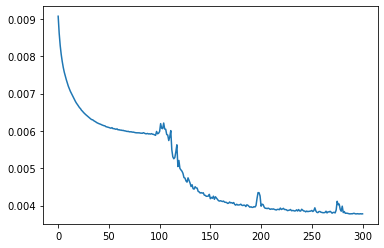

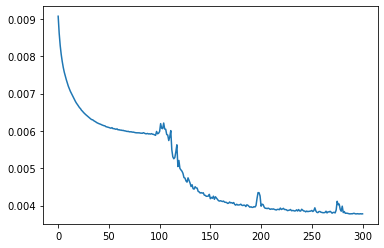

In [49]:
#---------------------
#  Data parameters to create the dataset 
error = 10
Area = 100
image_shape = (128, 128) 
batch_size = 2
image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
image_list =  data_after_before(image_list)

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_1'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

net = UNET_multi(input_channels, num_classes) 
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
#summary(net)
#sum(p.numel() for p in net.parameters() if p.requires_grad) 
tloss, tloss_list = training_Unet(dataloaders, epochs, device, loss_fn, net, optimizer, modelPath,  multi= True)
plt.plot(tloss_list)


### Multi 2

```
#---------------------
#  Data parameters to create the dataset 
error = 25
Area = 80
image_shape = (128, 128) 
batch_size = 2
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 101
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_2'
```

78
76 76 76
76 76 76 76
Images and masks are created
143 143
Current step: 0  Loss: 0.7529668807983398  


C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Proba_UNET\loss.py:26: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  intersection = torch.sum(probas * true_1_hot, dims)


Current step: 30  Loss: 0.7789510488510132  
Current step: 60  Loss: 0.7522484064102173  
Saving Model0.torch
Current step: 0  Loss: 0.692558765411377  
Current step: 30  Loss: 0.7211809158325195  
Current step: 60  Loss: 0.70595782995224  
Current step: 0  Loss: 0.6352459192276001  
Current step: 30  Loss: 0.6687978506088257  
Current step: 60  Loss: 0.6689711809158325  
Current step: 0  Loss: 0.590741753578186  
Current step: 30  Loss: 0.6270300149917603  
Current step: 60  Loss: 0.645609974861145  
Current step: 0  Loss: 0.5617049932479858  
Current step: 30  Loss: 0.5968159437179565  
Current step: 60  Loss: 0.632095456123352  
Current step: 0  Loss: 0.5454626083374023  
Current step: 30  Loss: 0.5779821872711182  
Current step: 60  Loss: 0.622754693031311  
Saving Model5.torch
Current step: 0  Loss: 0.5381395816802979  
Current step: 30  Loss: 0.5623232126235962  
Current step: 60  Loss: 0.6167294979095459  
Current step: 0  Loss: 0.5283750295639038  
Current step: 30  Loss: 0.554

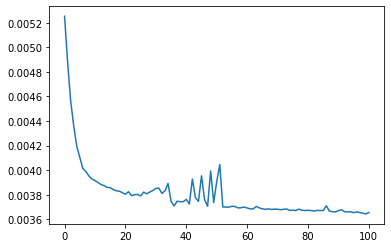

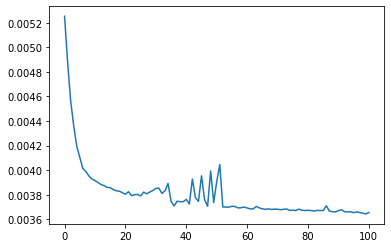

In [3]:
#---------------------
#  Data parameters to create the dataset 
error = 25
Area = 80
image_shape = (128, 128) 
batch_size = 2
image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 101
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_2'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

net = UNET_multi(input_channels, num_classes) 
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
#summary(net)
#sum(p.numel() for p in net.parameters() if p.requires_grad) 
tloss, tloss_list = training_Unet(dataloaders, epochs, device, loss_fn, net, optimizer, modelPath,  multi= True)
plt.plot(tloss_list)


### Multi 3

78
76 76 76
76 76 76 76
Images and masks are created
166 166
Current step: 0  Loss: 0.7254972457885742  
Current step: 30  Loss: 0.7015342712402344  
Current step: 60  Loss: 0.6921308040618896  
Saving Model0.torch
Current step: 0  Loss: 0.6372309923171997  
Current step: 30  Loss: 0.6258245706558228  
Current step: 60  Loss: 0.6188082695007324  
Current step: 0  Loss: 0.5808727741241455  
Current step: 30  Loss: 0.5695983171463013  
Current step: 60  Loss: 0.5641604661941528  
Current step: 0  Loss: 0.5493541955947876  
Current step: 30  Loss: 0.5337259769439697  
Current step: 60  Loss: 0.5304796695709229  
Current step: 0  Loss: 0.529996395111084  
Current step: 30  Loss: 0.509770393371582  
Current step: 60  Loss: 0.5117106437683105  
Current step: 0  Loss: 0.5180758237838745  
Current step: 30  Loss: 0.49451231956481934  
Current step: 60  Loss: 0.4965185523033142  
Saving Model5.torch
Current step: 0  Loss: 0.510358452796936  
Current step: 30  Loss: 0.4838292598724365  
Current 

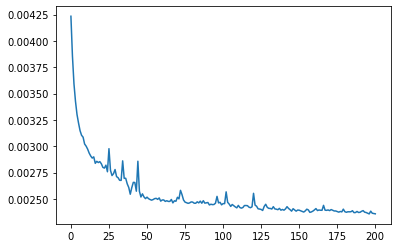

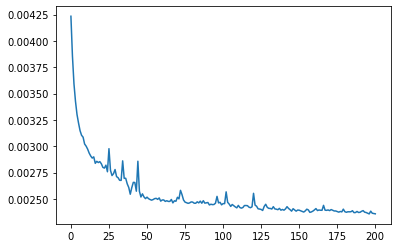

In [11]:
#---------------------
#  Data parameters to create the dataset 
error = 15
Area = 50
image_shape = (64, 64) 
batch_size = 2
image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 201
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_3'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

net = UNET_multi(input_channels, num_classes) 
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
#summary(net)
#sum(p.numel() for p in net.parameters() if p.requires_grad) 
tloss, tloss_list = training_Unet(dataloaders, epochs, device, loss_fn, net, optimizer, modelPath,  multi= True)
plt.plot(tloss_list)


### Multi 4


78
76 76 76
76 76 76 76
Images are created
143
Images and masks are created
143 143
Current step: 0  Loss: 0.7665634751319885  


C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Proba_UNET\loss.py:26: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  ..\aten\src\ATen\native\TensorIterator.cpp:918.)
  intersection = torch.sum(probas * true_1_hot, dims)


Current step: 30  Loss: 0.7938901782035828  
Current step: 60  Loss: 0.7745584845542908  
Saving Model0.torch
Current step: 0  Loss: 0.7097440958023071  
Current step: 30  Loss: 0.7408781051635742  
Current step: 60  Loss: 0.7151672840118408  
Current step: 0  Loss: 0.6500951051712036  
Current step: 30  Loss: 0.6943099498748779  
Current step: 60  Loss: 0.6770570278167725  
Current step: 0  Loss: 0.6136468648910522  
Current step: 30  Loss: 0.6663943529129028  
Current step: 60  Loss: 0.6537827253341675  
Current step: 0  Loss: 0.5920310020446777  
Current step: 30  Loss: 0.6444724798202515  
Current step: 60  Loss: 0.6390669345855713  
Current step: 0  Loss: 0.5794025659561157  
Current step: 30  Loss: 0.6294759511947632  
Current step: 60  Loss: 0.6303802728652954  
Saving Model5.torch
Current step: 0  Loss: 0.5733469724655151  
Current step: 30  Loss: 0.6196378469467163  
Current step: 60  Loss: 0.6245627403259277  
Current step: 0  Loss: 0.5701054334640503  
Current step: 30  Loss

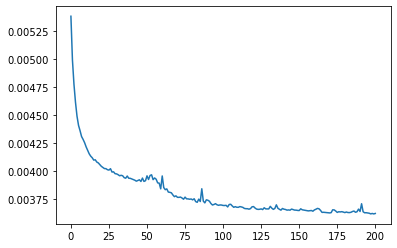

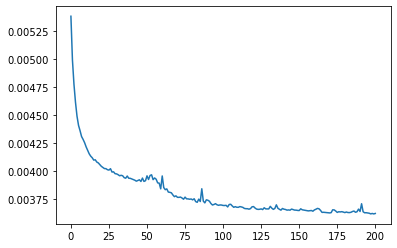

In [29]:
#---------------------
#  Data parameters to create the dataset 
error = 25
Area = 80
image_shape = (64, 64) 
batch_size = 2
image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
image_list =  data_after_before(image_list)
print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 1e-3  
epochs = 201
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_4'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

net = UNET_multi(input_channels, num_classes) 
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
#summary(net)
#sum(p.numel() for p in net.parameters() if p.requires_grad) 
tloss, tloss_list = training_Unet(dataloaders, epochs, device, loss_fn, net, optimizer, modelPath,  multi= True)
plt.plot(tloss_list)


### Multi 5


78
76 76 76
76 76 76 76
Images are created
166
Images and masks are created
166 166
Current step: 0  Loss: 0.7397866249084473  
Current step: 30  Loss: 0.6822645664215088  
Current step: 60  Loss: 0.615311861038208  
Saving Model0.torch
Current step: 0  Loss: 0.5660363435745239  
Current step: 30  Loss: 0.5322943925857544  
Current step: 60  Loss: 0.5152777433395386  
Current step: 0  Loss: 0.5200333595275879  
Current step: 30  Loss: 0.4868714213371277  
Current step: 60  Loss: 0.48078829050064087  
Current step: 0  Loss: 0.5028351545333862  
Current step: 30  Loss: 0.4693291187286377  
Current step: 60  Loss: 0.47578340768814087  
Current step: 0  Loss: 0.4952746033668518  
Current step: 30  Loss: 0.4607464671134949  
Current step: 60  Loss: 0.47299808263778687  
Current step: 0  Loss: 0.49003952741622925  
Current step: 30  Loss: 0.4561735987663269  
Current step: 60  Loss: 0.472583532333374  
Saving Model5.torch
Current step: 0  Loss: 0.48927009105682373  
Current step: 30  Loss: 0

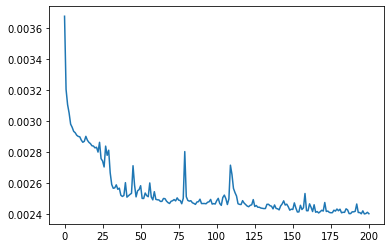

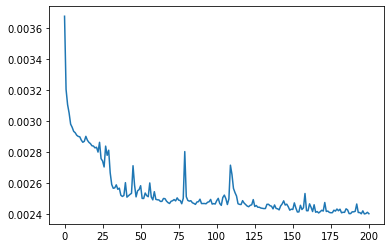

In [33]:
#---------------------
#  Data parameters to create the dataset 
error = 15
Area = 50
image_shape = (64, 64) 
batch_size = 2
image_list, mask_list = create_multi_input_data(error, Area, train_ = True)
image_list =  data_after_before(image_list)


print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model 
input_channels = 9
num_classes = 3
learning_rate = 3e-3  
epochs = 201
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_5'


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

net = UNET_multi(input_channels, num_classes) 
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)
#summary(net)
#sum(p.numel() for p in net.parameters() if p.requires_grad) 
tloss, tloss_list = training_Unet(dataloaders, epochs, device, loss_fn, net, optimizer, modelPath,  multi= True)
plt.plot(tloss_list)


## Test

In [31]:

def test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = False):
    loss_classes =  np.array([[0,0,0]])
    loss = []
    for _, batch in enumerate(dataloaders_test): 
        if multi:
                X, X_af, X_be, y = batch
                X, X_af, X_be, y = X.to(device), X_af.to(device), X_be.to(device), y.to(device)
                pred = net(X, X_af, X_be)
        else:
                X, y = batch
                X, y  = X.to(device), y.to(device)
                pred = net(X)

        seg = torch.argmax(pred, dim=1).numpy()[0]# torch.argmax(pred, 1).numpy()  # Get  prediction classes
        loss_v = loss_fn(pred, y)
        loss_classes_  = []
        for i in range(pred.shape[1]):
            y1 = 1*(y==i)
            pred1 = pred[:,i,:,:].unsqueeze(0)
            loss_classes_.append(-(loss_fn(pred1, y1).item()-1))
        #loss_classes_ , loss_v = loss_fn(pred, y, Test = True)
        loss_classes  = np.concatenate((loss_classes, np.array([loss_classes_])), axis = 0)
        loss.append(loss_v.item())
        print(loss_v)
        if plot_:
            print(loss_classes_)
            _, (ax1, ax2, ax3) = plt.subplots(1,3)
            ax1.imshow(X.squeeze().permute(1,2,0))
            ax2.imshow(seg)
            ax3.imshow(y.squeeze())
            plt.show()
    return loss_classes[1:,:].mean(0), np.mean(loss)


10
9 9 9
9 9 9 9
Images are created
22
Images and masks are created
22 22
tensor(0.5766, grad_fn=<RsubBackward1>)
[0.683583676815033, 0.5696282982826233, 0.5010997653007507]


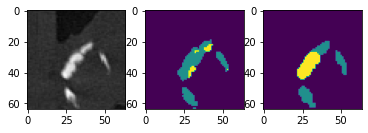

tensor(0.5115, grad_fn=<RsubBackward1>)
[0.758922815322876, 0.6045094132423401, 0.5559564232826233]


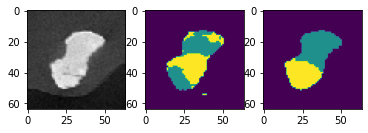

tensor(0.5772, grad_fn=<RsubBackward1>)
[0.6702123880386353, 0.5445973873138428, 0.5300763845443726]


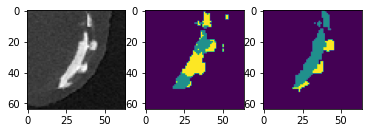

tensor(0.5225, grad_fn=<RsubBackward1>)
[0.7450536489486694, 0.7081054449081421, 0.4920881986618042]


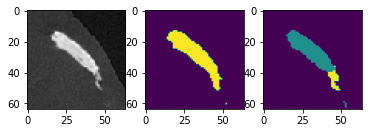

tensor(0.6106, grad_fn=<RsubBackward1>)
[0.7024773955345154, 0.4812166690826416, 0.530514121055603]


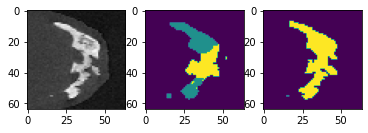

tensor(0.4795, grad_fn=<RsubBackward1>)
[0.8572848439216614, 0.7398779392242432, 0.48806053400039673]


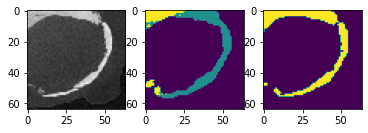

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6437, grad_fn=<RsubBackward1>)
[0.8276991844177246, 0.43425238132476807, 0.42399662733078003]


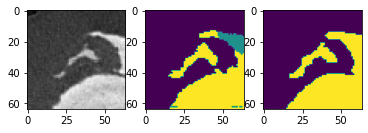

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4535, grad_fn=<RsubBackward1>)
[0.8598694801330566, 0.7975909113883972, 0.48596101999282837]


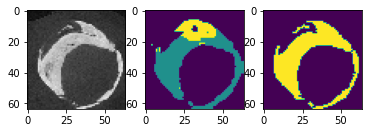

tensor(0.6180, grad_fn=<RsubBackward1>)
[0.575122058391571, 0.49997562170028687, 0.5580064058303833]


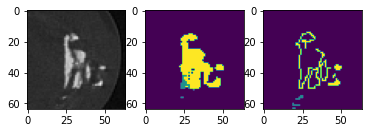

tensor(0.6193, grad_fn=<RsubBackward1>)
[0.5688580274581909, 0.5015730261802673, 0.5472376346588135]


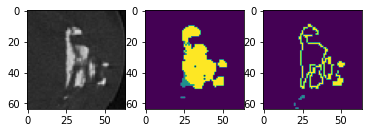

tensor(0.5205, grad_fn=<RsubBackward1>)
[0.7124099135398865, 0.7049435973167419, 0.4961845874786377]


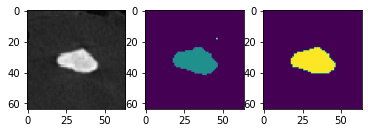

tensor(0.5340, grad_fn=<RsubBackward1>)
[0.7567307949066162, 0.5614537000656128, 0.5765719413757324]


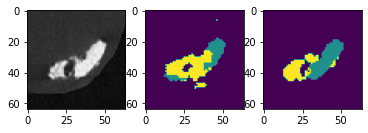

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6497, grad_fn=<RsubBackward1>)
[0.7523969411849976, 0.4842129349708557, 0.4917975068092346]


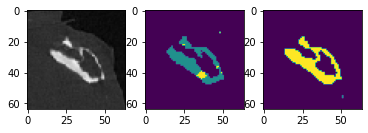

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6260, grad_fn=<RsubBackward1>)
[0.8344662189483643, 0.4755258560180664, 0.5052096247673035]


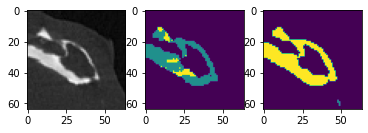

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4975, grad_fn=<RsubBackward1>)
[0.8168256282806396, 0.49425625801086426, 0.6979233622550964]


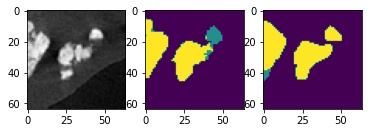

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5878, grad_fn=<RsubBackward1>)
[0.6630498170852661, 0.49667054414749146, 0.5885965824127197]


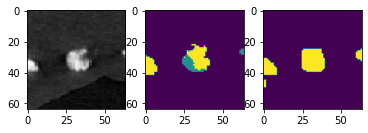

tensor(0.6018, grad_fn=<RsubBackward1>)
[0.9197927713394165, 0.4576866626739502, 0.512624979019165]


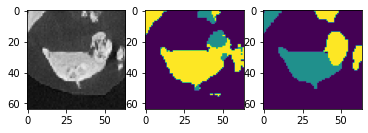

tensor(0.4399, grad_fn=<RsubBackward1>)
[0.8768113851547241, 0.6331305503845215, 0.6362916231155396]


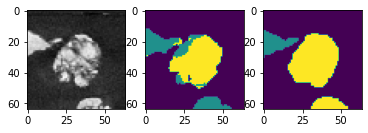

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5292, grad_fn=<RsubBackward1>)
[0.7823836803436279, 0.4930201768875122, 0.6619408130645752]


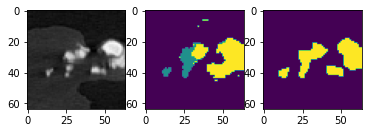

tensor(0.4745, grad_fn=<RsubBackward1>)
[0.8653052449226379, 0.7401639819145203, 0.469541072845459]


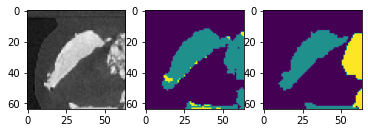

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5731, grad_fn=<RsubBackward1>)
[0.7534698247909546, 0.47873497009277344, 0.6030020713806152]


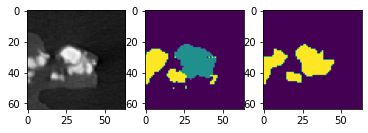

tensor(0.5319, grad_fn=<RsubBackward1>)
[0.7914501428604126, 0.570402204990387, 0.5458370447158813]


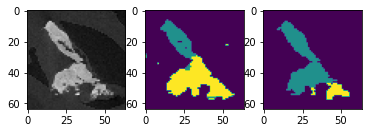

[0.76246254 0.56688766 0.54084174] 0.5535548979585821


In [34]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
image_list =  data_after_before(image_list)

print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)

#----------------------
# Model  Parameters
input_channels = 9
num_classes = 3

loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_5'
epoch_init = '200.torch'

#----------------------
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
net = UNET_multi(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 4  Multi Input
loss_fn  =  DiceLoss()  
dice_score_classes, loss = test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = True )
print(dice_score_classes, loss)


In [ ]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
image_list =  data_after_before(image_list)

print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)

#----------------------
# Model  Parameters
input_channels = 9
num_classes = 3
# learning_rate = 1e-3  
# epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_4'
epoch_init = '200.torch'

#----------------------
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
net = UNET_multi(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 4  Multi Input
loss_fn  =  DiceLoss()  
dice_score_classes, loss = test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = True )
print(dice_score_classes, loss)


10
9 9 9
9 9 9 9
Images are created
22
Images and masks are created
22 22
tensor(0.5787, grad_fn=<RsubBackward1>)
[0.6813270449638367, 0.6104164719581604, 0.5098326206207275]


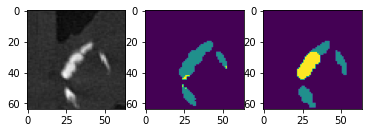

tensor(0.4835, grad_fn=<RsubBackward1>)
[0.7677420377731323, 0.6420348286628723, 0.5915050506591797]


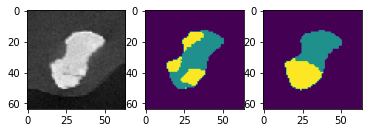

tensor(0.5793, grad_fn=<RsubBackward1>)
[0.6698312759399414, 0.614809513092041, 0.5172238349914551]


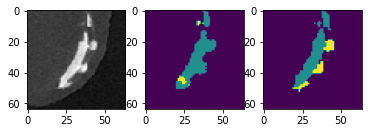

tensor(0.5209, grad_fn=<RsubBackward1>)
[0.7363253235816956, 0.710006058216095, 0.49841248989105225]


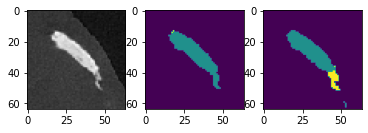

tensor(0.6133, grad_fn=<RsubBackward1>)
[0.7078680992126465, 0.47532761096954346, 0.5655727982521057]


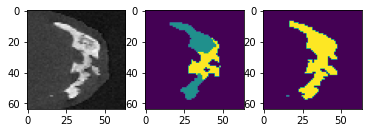

tensor(0.4422, grad_fn=<RsubBackward1>)
[0.8840222358703613, 0.8204477429389954, 0.49171680212020874]


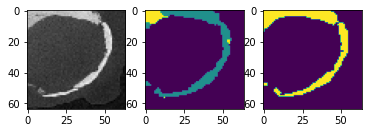

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5789, grad_fn=<RsubBackward1>)
[0.8287548422813416, 0.5576910376548767, 0.433851957321167]


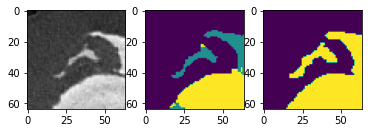

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4483, grad_fn=<RsubBackward1>)
[0.8789454698562622, 0.803642213344574, 0.4779823422431946]


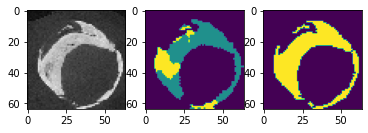

tensor(0.6283, grad_fn=<RsubBackward1>)
[0.579757571220398, 0.5013426542282104, 0.5524724721908569]


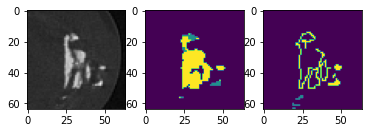

tensor(0.6270, grad_fn=<RsubBackward1>)
[0.5784991979598999, 0.5111493468284607, 0.5493711233139038]


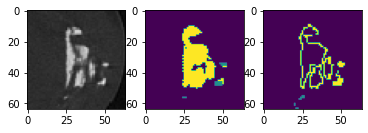

tensor(0.5246, grad_fn=<RsubBackward1>)
[0.7087854146957397, 0.709071934223175, 0.49861079454421997]


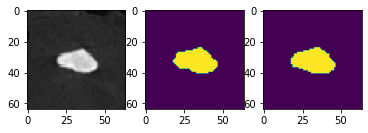

tensor(0.5183, grad_fn=<RsubBackward1>)
[0.7655566930770874, 0.5802206993103027, 0.6231790781021118]


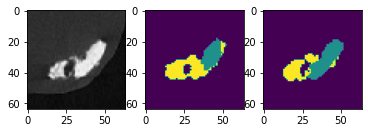

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5939, grad_fn=<RsubBackward1>)
[0.7399459481239319, 0.48700785636901855, 0.6059461832046509]


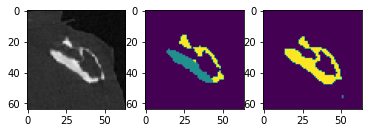

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5969, grad_fn=<RsubBackward1>)
[0.8055146932601929, 0.47771257162094116, 0.5884354710578918]


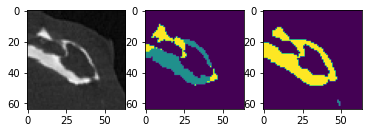

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5132, grad_fn=<RsubBackward1>)
[0.8134356141090393, 0.4799664616584778, 0.710343062877655]


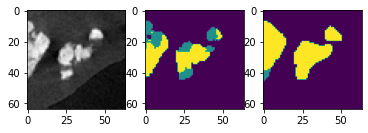

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6068, grad_fn=<RsubBackward1>)
[0.6619390249252319, 0.49215149879455566, 0.587225079536438]


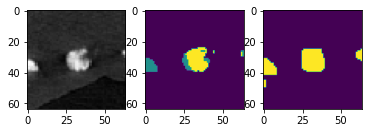

tensor(0.5071, grad_fn=<RsubBackward1>)
[0.9447816610336304, 0.5733492970466614, 0.5694324970245361]


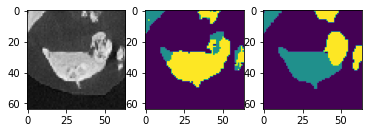

tensor(0.5043, grad_fn=<RsubBackward1>)
[0.8853204846382141, 0.49134552478790283, 0.7066051363945007]


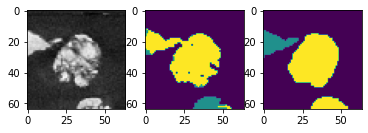

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4878, grad_fn=<RsubBackward1>)
[0.7763054370880127, 0.49873679876327515, 0.758427619934082]


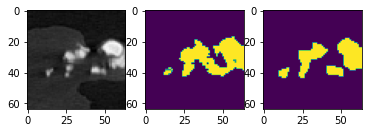

tensor(0.4323, grad_fn=<RsubBackward1>)
[0.8884665966033936, 0.7690818905830383, 0.5551407337188721]


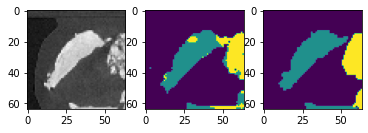

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4806, grad_fn=<RsubBackward1>)
[0.7772646546363831, 0.499184250831604, 0.7771490812301636]


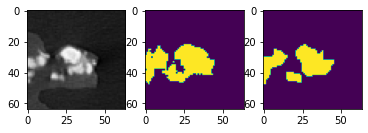

tensor(0.5979, grad_fn=<RsubBackward1>)
[0.8220078945159912, 0.46641504764556885, 0.5497922301292419]


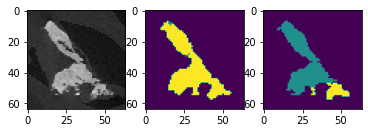

[0.76829078 0.58050506 0.57810129] 0.5392786128954454


In [32]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
image_list =  data_after_before(image_list)

print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)

#----------------------
# Model  Parameters
input_channels = 9
num_classes = 3
# learning_rate = 1e-3  
# epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_4'
epoch_init = '200.torch'

#----------------------
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
net = UNET_multi(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 4  Multi Input
loss_fn  =  DiceLoss()  
dice_score_classes, loss = test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = True )
print(dice_score_classes, loss)


10
9 9 9
9 9 9 9
Images and masks are created
22 22
tensor(0.5912, grad_fn=<RsubBackward1>)
[0.6923623085021973, 0.5830655097961426, 0.4865637421607971]


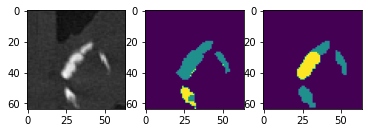

tensor(0.5419, grad_fn=<RsubBackward1>)
[0.7604129910469055, 0.5709657669067383, 0.5633417367935181]


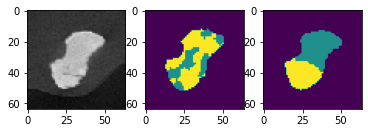

tensor(0.5305, grad_fn=<RsubBackward1>)
[0.6743799448013306, 0.6232746839523315, 0.5474902987480164]


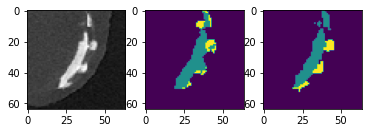

tensor(0.5224, grad_fn=<RsubBackward1>)
[0.7421730160713196, 0.7054479122161865, 0.4962309002876282]


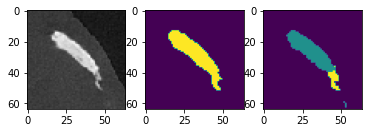

tensor(0.5826, grad_fn=<RsubBackward1>)
[0.7148102521896362, 0.4845470190048218, 0.6115422248840332]


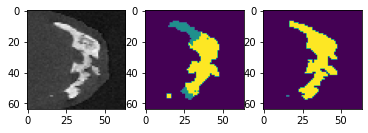

tensor(0.4655, grad_fn=<RsubBackward1>)
[0.8658196926116943, 0.7908568978309631, 0.4900769591331482]


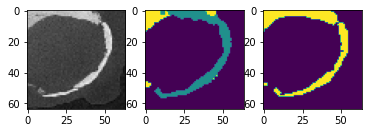

tensor(0.4978, grad_fn=<RsubBackward1>)
[0.8279979825019836, 0.6974132061004639, 0.4636843204498291]


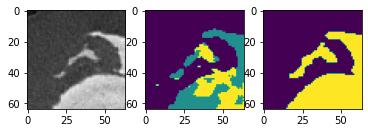

tensor(0.4234, grad_fn=<RsubBackward1>)
[0.8481438755989075, 0.8426432609558105, 0.49596232175827026]


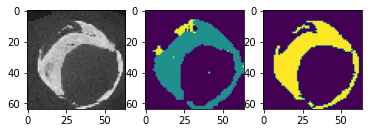

tensor(0.6299, grad_fn=<RsubBackward1>)
[0.5846235156059265, 0.484049916267395, 0.551798403263092]


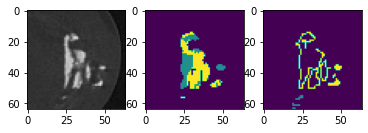

tensor(0.6236, grad_fn=<RsubBackward1>)
[0.5803871154785156, 0.48891401290893555, 0.5552975535392761]


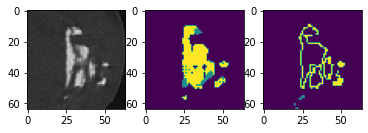

tensor(0.5233, grad_fn=<RsubBackward1>)
[0.7151048183441162, 0.698103129863739, 0.4999856948852539]


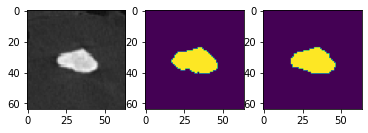

tensor(0.5145, grad_fn=<RsubBackward1>)
[0.7636663913726807, 0.5948870778083801, 0.6019325256347656]


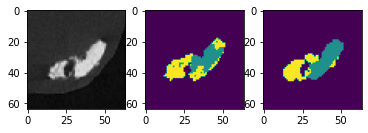

tensor(0.5607, grad_fn=<RsubBackward1>)
[0.7407125234603882, 0.48629844188690186, 0.6470053791999817]


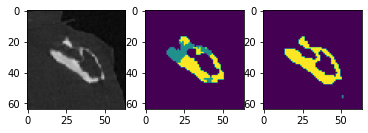

tensor(0.5040, grad_fn=<RsubBackward1>)
[0.8256703615188599, 0.482635498046875, 0.72018963098526]


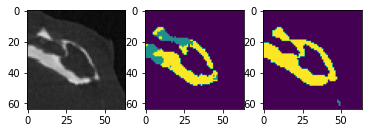

tensor(0.4863, grad_fn=<RsubBackward1>)
[0.8159136176109314, 0.4875659942626953, 0.7515057325363159]


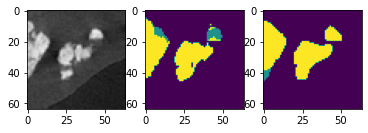

tensor(0.6043, grad_fn=<RsubBackward1>)
[0.6776878237724304, 0.48453736305236816, 0.5767344832420349]


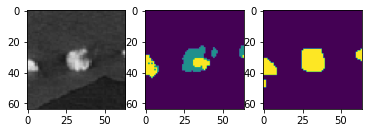

tensor(0.5199, grad_fn=<RsubBackward1>)
[0.902475118637085, 0.6181575059890747, 0.5571112632751465]


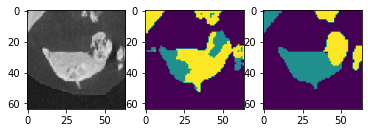

tensor(0.4842, grad_fn=<RsubBackward1>)
[0.8485961556434631, 0.5712222456932068, 0.6766986846923828]


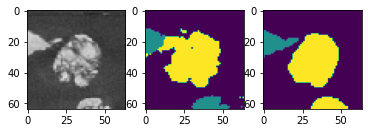

tensor(0.5528, grad_fn=<RsubBackward1>)
[0.7840890884399414, 0.4826871156692505, 0.6535382270812988]


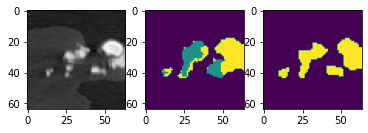

tensor(0.4294, grad_fn=<RsubBackward1>)
[0.8576839566230774, 0.7644737958908081, 0.5272717475891113]


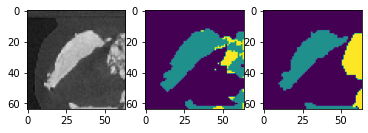

tensor(0.5412, grad_fn=<RsubBackward1>)
[0.7746288180351257, 0.4810124635696411, 0.6722018718719482]


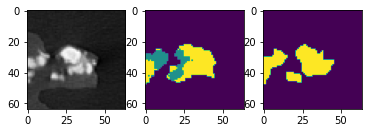

tensor(0.6121, grad_fn=<RsubBackward1>)
[0.7948617935180664, 0.5232009887695312, 0.5274198055267334]


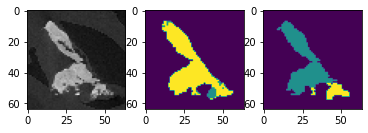

[0.76328187 0.58845272 0.57607198] 0.5336977676911787


In [15]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)

#----------------------
# Model  Parameters
input_channels = 9
num_classes = 3
# learning_rate = 1e-3  
# epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_3'
epoch_init = '200.torch'

#----------------------
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
net = UNET_multi(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 3  Multi Input
loss_fn  =  DiceLoss()  
dice_score_classes, loss = test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = True )
print(dice_score_classes, loss)


In [ ]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
print('Images and masks are created')
print(len(image_list), len(mask_list))  

data = Segmentation_after_before(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)

#----------------------
# Model  Parameters
input_channels = 9
num_classes = 3
# learning_rate = 1e-3  
# epochs = 301
loss_fn  =  DiceLoss() 
folder_name = 'model_unet_multi_3'
epoch_init = '100.torch'

#----------------------
# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
net = UNET_multi(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 3  Multi Input
loss_fn  =  DiceLoss()  
dice_score_classes, loss = test_multi(net, loss_fn, dataloaders_test, device, plot_ = True, multi = True )
print(dice_score_classes, loss)


### Model multi 2

10
9 9 9
9 9 9 9
Images and masks are created
22 22
tensor(0.5870, grad_fn=<RsubBackward1>)
[0.6796306371688843, 0.5862571597099304, 0.5339270234107971]


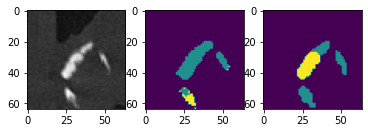

tensor(0.6195, grad_fn=<RsubBackward1>)
[0.7484350204467773, 0.5127708315849304, 0.5220001339912415]


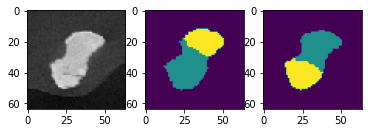

tensor(0.5697, grad_fn=<RsubBackward1>)
[0.6581817865371704, 0.58479905128479, 0.5401871204376221]


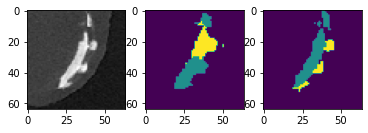

tensor(0.5303, grad_fn=<RsubBackward1>)
[0.7278923988342285, 0.6798206567764282, 0.5059332847595215]


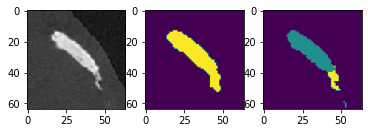

tensor(0.5686, grad_fn=<RsubBackward1>)
[0.6828987002372742, 0.4954890012741089, 0.6600769758224487]


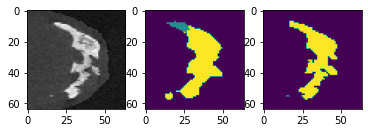

tensor(0.4454, grad_fn=<RsubBackward1>)
[0.8290952444076538, 0.7981695532798767, 0.48537421226501465]


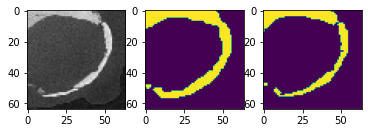

tensor(0.6131, grad_fn=<RsubBackward1>)
[0.8038445711135864, 0.5118118524551392, 0.40322351455688477]


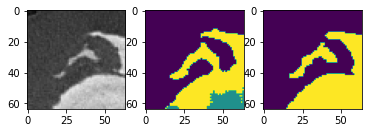

tensor(0.4649, grad_fn=<RsubBackward1>)
[0.8237148523330688, 0.7757891416549683, 0.4659721851348877]


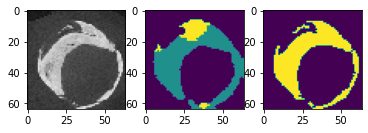

tensor(0.6155, grad_fn=<RsubBackward1>)
[0.5670639872550964, 0.5002978444099426, 0.5723455548286438]


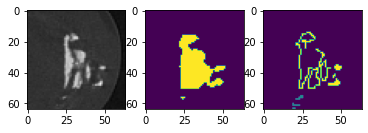

tensor(0.6141, grad_fn=<RsubBackward1>)
[0.5694869756698608, 0.5041025280952454, 0.5749949216842651]


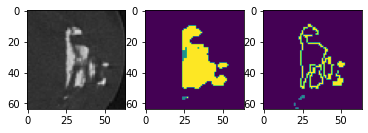

tensor(0.5817, grad_fn=<RsubBackward1>)
[0.7081412672996521, 0.6068678498268127, 0.4848201274871826]


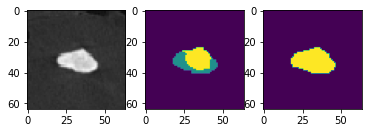

tensor(0.5544, grad_fn=<RsubBackward1>)
[0.7574445605278015, 0.6241377592086792, 0.5569368600845337]


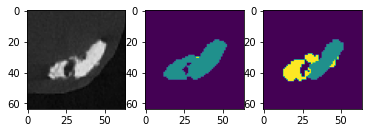

tensor(0.6300, grad_fn=<RsubBackward1>)
[0.7313582301139832, 0.47881460189819336, 0.6094187498092651]


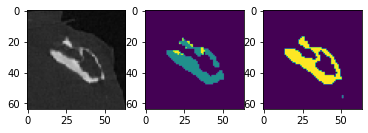

tensor(0.5255, grad_fn=<RsubBackward1>)
[0.8110970258712769, 0.48320508003234863, 0.7180244326591492]


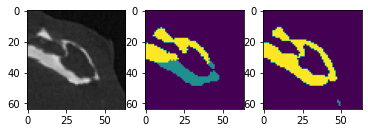

tensor(0.5180, grad_fn=<RsubBackward1>)
[0.8080586791038513, 0.47354620695114136, 0.7376962304115295]


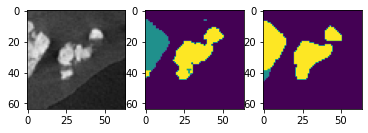

tensor(0.6602, grad_fn=<RsubBackward1>)
[0.6704356074333191, 0.4769921898841858, 0.5600305795669556]


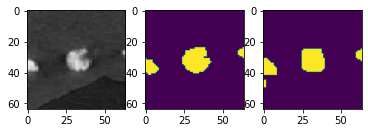

tensor(0.4884, grad_fn=<RsubBackward1>)
[0.891090452671051, 0.599399745464325, 0.5815392136573792]


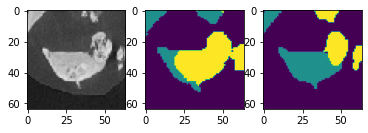

tensor(0.5173, grad_fn=<RsubBackward1>)
[0.8370050191879272, 0.5006476640701294, 0.7003153562545776]


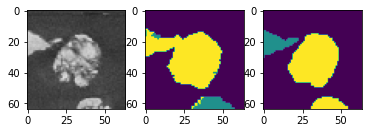

tensor(0.4639, grad_fn=<RsubBackward1>)
[0.7917986512184143, 0.4996682405471802, 0.7998120188713074]


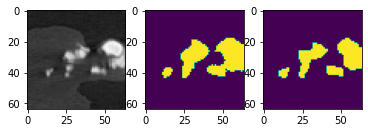

tensor(0.4630, grad_fn=<RsubBackward1>)
[0.831112802028656, 0.7309137582778931, 0.518909752368927]


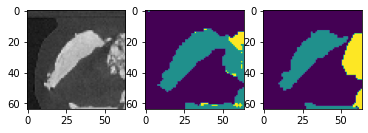

tensor(0.4726, grad_fn=<RsubBackward1>)
[0.777094841003418, 0.4996943473815918, 0.7905367016792297]


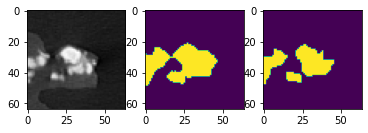

tensor(0.5781, grad_fn=<RsubBackward1>)
[0.7764219045639038, 0.5923884510993958, 0.5114613771438599]


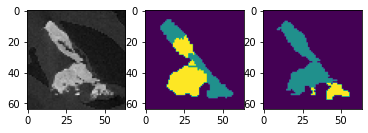

[0.74915015 0.56889016 0.58334256] 0.5491387871178713


In [20]:
#---------------------
# TEST:
#---------------------
#  Data parameters to create the dataset 
error = 20
Area = 100
train = False
image_shape = (64, 64) 
batch_size = 1
# image_list, mask_list = create_multi_input_data(error, Area, train_ = train)
# print('Images and masks are created')
# print(len(image_list), len(mask_list))  
# data = Segmentation_after_before(image_list, mask_list, image_shape)
# dataloaders_test = torch.utils.data.DataLoader(data, batch_size)
from data_loader_seg import SegmentationDataset
path_ori = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\originals_180919\originals'
path = r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg\ora_180919\Layers'
image_Paths, mask_Paths = create_dir_paths(path, train= False)
image_list , mask_list, _ =  create_box_images(image_Paths, mask_Paths, error, Area)
print('Images and masks are created')
print(len(image_list), len(mask_list))     
data = SegmentationDataset(image_list, mask_list, image_shape)
dataloaders_test = torch.utils.data.DataLoader(data, batch_size)
#----------------------
# Model  Parameters
input_channels = 3
num_classes = 3

loss_fn  =  DiceLoss() 
folder_name = 'model_unet_1'
epoch_init = '100.torch'
#----------------------
# Model initialization
from unet_3block_conv import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelPath = os.path.join(r'C:\Users\kmorales\Desktop\2DO PhD\Strasbourg\Hugo_seg', folder_name)
#net = UNET_multi(input_channels, num_classes)
net = UNET(input_channels, num_classes) 
net.to(device)
net.load_state_dict(torch.load(os.path.join(modelPath , epoch_init))) # Load trained model
net.eval()
#######################################
# UNET Model 1
loss_fn  =  DiceLoss()  
def test(net, loss_fn, dataloaders_test, device, ProbaUnet = True, plot_ = True):
    loss_classes =  np.array([[0,0,0]])
    loss = []
    for _, batch in enumerate(dataloaders_test): 
        X, y = batch

        X, y = X.to(device), y.to(device)
        
        if ProbaUnet:
            _,_, pred =  net(X, y)
        else:
            pred =  net(X)

        seg = torch.argmax(pred, dim=1).numpy()[0]# torch.argmax(pred, 1).numpy()  # Get  prediction classes
        loss_v = loss_fn(pred, y)
        loss_classes_  = []
        for i in range(pred.shape[1]):
            y1 = 1*(y==i)
            pred1 = pred[:,i,:,:].unsqueeze(0)
            loss_classes_.append(-(loss_fn(pred1, y1).item()-1))
        #loss_classes_ , loss_v = loss_fn(pred, y, Test = True)
        loss_classes  = np.concatenate((loss_classes, np.array([loss_classes_])), axis = 0)
        loss.append(loss_v.item())
        print(loss_v)
        if plot_:
            print(loss_classes_)
            _, (ax1, ax2, ax3) = plt.subplots(1,3)
            ax1.imshow(X.squeeze().permute(1,2,0))
            ax2.imshow(seg)
            ax3.imshow(y.squeeze())
            plt.show()
    return loss_classes[1:,:].mean(0), np.mean(loss)

dice_score_classes, loss = test(net, loss_fn, dataloaders_test, device, plot_ = True , ProbaUnet= False)
print(dice_score_classes, loss)